In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. CARGA DE DATOS
archivo = 'est_19_limpio.csv'
df = pd.read_csv(archivo, parse_dates=['datetime'], index_col='datetime')

# 2. SELECCIÓN DE VARIABLES PARA EL CLUSTERING
# No metemos la lluvia como target, sino como característica para ver cómo se agrupa.
features = ['temperatura', 'humedad', 'presion', 'velocidad', 'radiacion', 'precipitacion_real']

# Filtramos solo las columnas que existen y eliminamos filas vacías
cols_validas = [c for c in features if c in df.columns]
df_cluster = df[cols_validas].dropna()

# 3. ESCALADO DE DATOS (StandardScaler)
# Transforma los datos para que media=0 y desviación=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print("Datos escalados y listos para agrupar.")
print(f"Dimensiones: {X_scaled.shape}")

Datos escalados y listos para agrupar.
Dimensiones: (382392, 6)


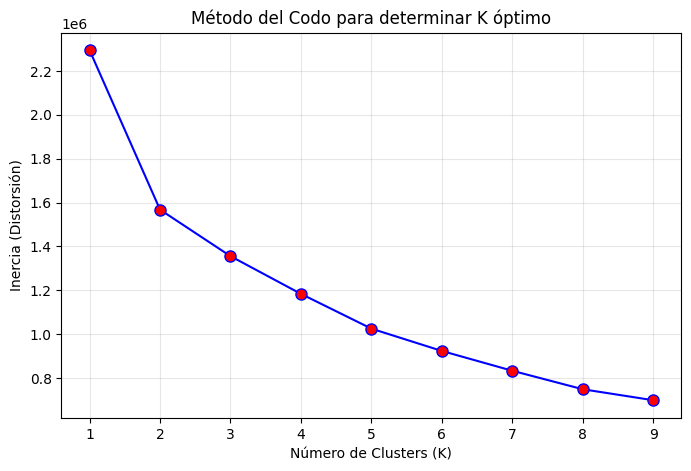

In [ ]:
# Calcular la inercia (suma de distancias al cuadrado) para diferentes K
inercias = []
rango_k = range(1, 10)

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inercias.append(kmeans.inertia_)

# Graficar el Codo
plt.figure(figsize=(8, 5))
plt.plot(rango_k, inercias, 'bo-', markerfacecolor='red', markersize=8)
plt.title('Método del Codo para determinar K óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (Distorsión)')
plt.grid(True, alpha=0.3)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


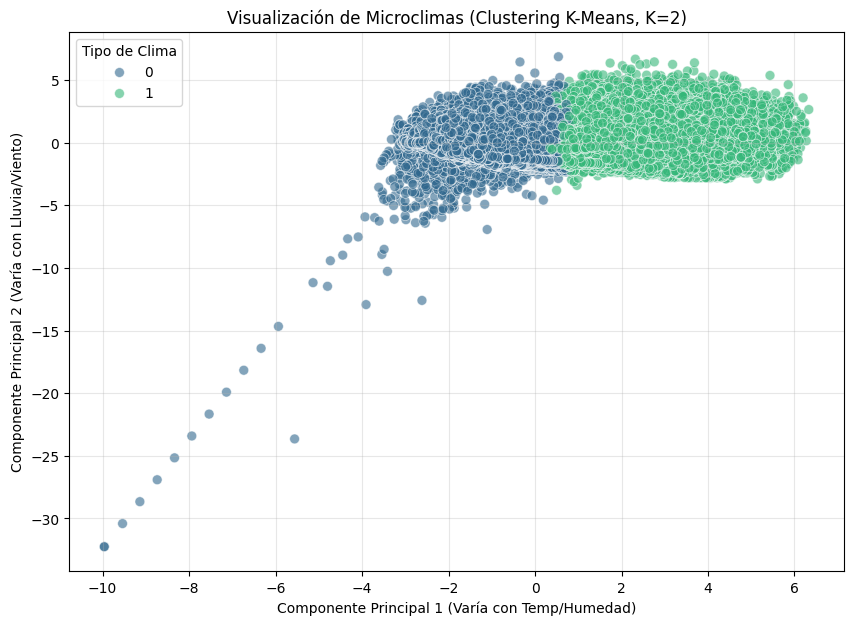

In [ ]:

K_OPTIMO = 2

# 1. Aplicar K-Means Final
kmeans = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Guardamos el cluster en el dataframe original para analizarlo
df_cluster['Cluster'] = clusters

# 2. Visualización con PCA
pca = PCA(n_components=2)
componentes = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=componentes[:, 0], y=componentes[:, 1],
                hue=df_cluster['Cluster'], palette='viridis', s=50, alpha=0.6)
plt.title(f'Visualización de Microclimas (Clustering K-Means, K={K_OPTIMO})')
plt.xlabel('Componente Principal 1 (Varía con Temp/Humedad)')
plt.ylabel('Componente Principal 2 (Varía con Lluvia/Viento)')
plt.legend(title='Tipo de Clima')
plt.grid(True, alpha=0.3)
plt.show()

--- CARACTERIZACIÓN DE LOS MICROCLIMAS DETECTADOS ---
         temperatura    humedad     presion  velocidad   radiacion  \
Cluster                                                              
0          16.560338  85.016876  610.890732   1.086605   42.270414   
1          21.899203  65.155740  609.522759   1.253542  386.616435   

         precipitacion_real  Horas_Detectadas  
Cluster                                        
0                  0.023715            258892  
1                  0.000983            123500  


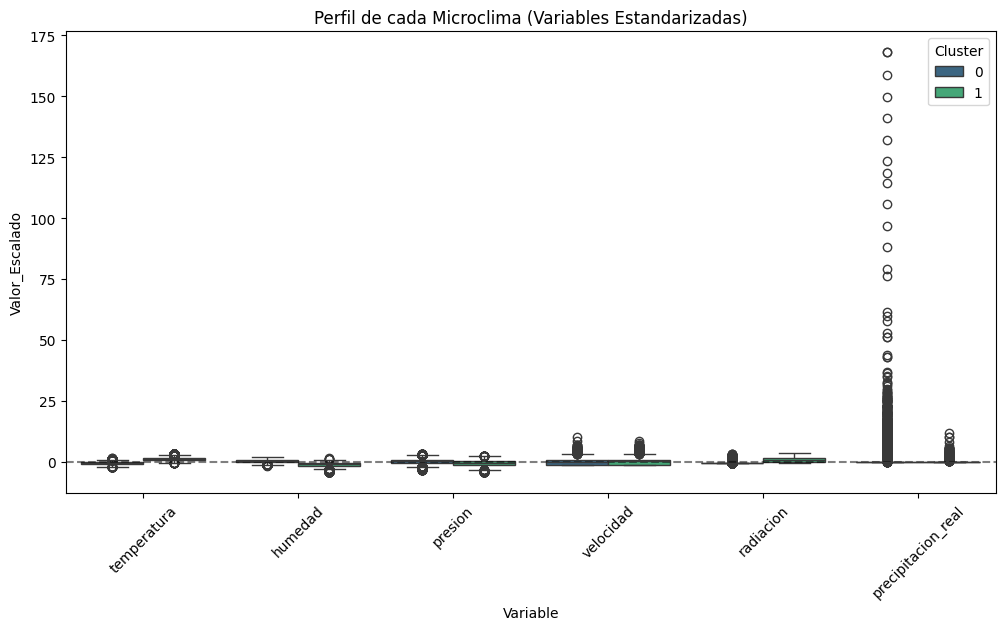

In [ ]:
# Agrupamos por cluster y sacamos el promedio de las variables originales
perfil_microclimas = df_cluster.groupby('Cluster').mean()

# Agregamos la cantidad de horas que pertenece a cada clima
perfil_microclimas['Horas_Detectadas'] = df_cluster['Cluster'].value_counts()

print("--- CARACTERIZACIÓN DE LOS MICROCLIMAS DETECTADOS ---")
print(perfil_microclimas)

# Visualización paralela (Boxplots) para entender las diferencias
# Normalizamos para que quepan en el gráfico
df_norm = pd.DataFrame(X_scaled, columns=cols_validas)
df_norm['Cluster'] = clusters

df_melt = df_norm.melt(id_vars='Cluster', var_name='Variable', value_name='Valor_Escalado')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melt, x='Variable', y='Valor_Escalado', hue='Cluster', palette='viridis')
plt.title('Perfil de cada Microclima (Variables Estandarizadas)')
plt.axhline(0, color='k', linestyle='--', alpha=0.5) # Línea del promedio global
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382392 entries, 2012-03-28 01:06:28 to 2016-01-07 11:53:54
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fecha               382392 non-null  object 
 1   hora                382392 non-null  object 
 2   temperatura         382392 non-null  float64
 3   velocidad           382392 non-null  float64
 4   direccion           382392 non-null  float64
 5   direccion_rosa      382392 non-null  object 
 6   caudal              382392 non-null  float64
 7   presion             382392 non-null  float64
 8   humedad             382392 non-null  float64
 9   precipitacion       382392 non-null  float64
 10  precipitacion_real  382392 non-null  float64
 11  radiacion           382392 non-null  float64
 12  evapotranspiracion  382392 non-null  float64
 13  evapo_real          382392 non-null  float64
 14  nivel               382392 non-null  float64
 15  

In [ ]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382392 entries, 2012-03-28 01:06:28 to 2016-01-07 11:53:54
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   temperatura         382392 non-null  float64
 1   humedad             382392 non-null  float64
 2   presion             382392 non-null  float64
 3   velocidad           382392 non-null  float64
 4   radiacion           382392 non-null  float64
 5   precipitacion_real  382392 non-null  float64
 6   Cluster             382392 non-null  int32  
dtypes: float64(6), int32(1)
memory usage: 21.9 MB


In [ ]:
df_cluster.head(100)

,temperatura,humedad,presion,velocidad,radiacion,precipitacion_real,Cluster
datetime,,,,,,,
2012-03-28 01:06:28,15.56,86.0,610.06,0.00,0.0,0.0,0
2012-03-28 01:11:28,15.39,88.0,610.06,0.00,0.0,0.0,0
2012-03-28 01:16:31,15.39,88.0,610.06,0.00,0.0,0.0,0
2012-03-28 01:46:31,15.44,86.0,610.06,0.00,0.0,0.0,0
2012-03-28 01:51:35,15.56,86.0,610.06,0.00,0.0,0.0,0
...,...,...,...,...,...,...,...
2012-03-28 09:37:01,20.44,71.0,611.43,0.00,738.0,0.0,1
2012-03-28 09:37:11,20.44,71.0,611.43,0.45,738.0,0.0,1
2012-03-28 09:42:02,20.56,71.0,611.43,1.34,807.0,0.0,1


In [ ]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382392 entries, 2012-03-28 01:06:28 to 2016-01-07 11:53:54
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   temperatura         382392 non-null  float64
 1   humedad             382392 non-null  float64
 2   presion             382392 non-null  float64
 3   velocidad           382392 non-null  float64
 4   radiacion           382392 non-null  float64
 5   precipitacion_real  382392 non-null  float64
 6   Cluster             382392 non-null  int32  
dtypes: float64(6), int32(1)
memory usage: 21.9 MB


In [ ]:
df_cluster.to_csv('df_cluster_19.csv', index=False)